# Grover's algorithm in pyQuil

![TeamName](https://media.giphy.com/media/3og0ITQOC5wlyk8ffy/giphy.gif "pied pipper")

In [1]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt

from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.quil import DefGate

In [2]:
def create_Zf(f, n):
    """
    Function to create Zf matrix
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be (len(input to f))
    
    @return: Numpy matrix Zf
    """
    dim = 2**n
    # creating a 2^n x 2^n zeros matrix.
    Zf = np.eye(dim, dtype=int)
    # This creates a list of the different permutations of n bits.
    lst_bitseq = list(map(list, itertools.product([0, 1], repeat=n)))
    for col, bitseq in enumerate(lst_bitseq):
        if f(bitseq) == 1:
            Zf[col, col] = -1
            break
    return Zf

In [3]:
def create_Z0(n):
    """
    Function to create Z0 matrix
    
    @param n: Number of qubits. This should be (len(input to f))
    
    @return: Numpy matrix Z0. We are actually returning -Z0 here.
    """
    dim = 2**n
    Z0 = -np.eye(dim, dtype=int)
    Z0[0,0] = 1
    return Z0

In [4]:
def num_iters(n):
    """
    This function calculates the number of iterations required for function with input size n
    
    @param n: Number of qubits. This should be len(input to f)
    
    @return: Number of executions of G matrix
    """
    return int(np.floor((np.pi/4)*np.sqrt(2**n)))

In [5]:
def create_grover_circuit(f, n):
    """
    This function will create the program.
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be len(input to f)
    
    @return: Pyquil Program
    """
    zf = create_Zf(f, n)
    z0 = create_Z0(n)
    # Get the Quil definition for the new gate
    zf_definition = DefGate("ZF", zf)
    z0_definition = DefGate("Z0",z0)
    # Get the gate constructor
    ZF = zf_definition.get_constructor()
    Z0 = z0_definition.get_constructor()
    
    p = Program()
    p += zf_definition
    p += z0_definition
    #p += X(n-1) # Make the last
    for i in range(n):
        p += H(i)
    
    k = num_iters(n)
    for i in range(k):
        p += Program("ZF {}".format(' '.join(str(x) for x in list(range(0, n)))))
        for i in range(n):
            p += H(i)
        p += Program("Z0 {}".format(' '.join(str(x) for x in list(range(0, n)))))
        for i in range(n):
            p += H(i)
    #print(p)
    return p

In [6]:
def run_circuit(f, n, n_trials):
    """
    creates and runs a circuit
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be 1+(len(input to f))
    
    @return: result
    """
    print("*"*50)
    p = create_grover_circuit(f, n)
    qc = get_qc('Aspen-4-16Q-A')
    result = qc.run_and_measure(p, trials=n_trials)  # We only run 1 trial here because it is deterministic with no noise
    
    result_str = ''
    prob = 1
    for i in range(n):
        out = np.array(np.unique(result[i], return_counts=True)).T
        if len(out) == 1:
            print("qubit {} is {} with probability 100%".format(i, out[0][0]))
            x = out[0][0]
        else:
            if out[0][1] > out[1][1]:
                print("qubit {} is {} with probability {}%".format(i, out[0][0], out[0][1]*100/n_trials))
                x = out[0][0]
                prob *= (out[0][1]/n_trials)
            else:
                print("qubit {} is {} with probability {}%".format(i, out[1][0], out[1][1]*100/n_trials))
                x = out[1][0]
                prob *= (out[1][1]/n_trials)
        result_str += str(x)
    print("f(x) = 1 for input x={} with probability {:.3f}%".format(result_str,prob*100))
    print("*"*50)

# Do we see if different functions give different execution times?

Running our circuit for all 16 possible functions for n=4

In [7]:
time_it_took = []
lst_bitseq = list(map(list, itertools.product([0, 1], repeat=4)))

for i in range(len(lst_bitseq)):
    start = time.time()
    run_circuit(lambda x: 1 if x == lst_bitseq[i] else 0, 4,1000)
    end = time.time()
    time_it_took.append(end-start)

**************************************************
qubit 0 is 1 with probability 59.5%
qubit 1 is 1 with probability 56.2%
qubit 2 is 0 with probability 54.6%
qubit 3 is 1 with probability 52.7%
f(x) = 1 for input x=1101 with probability 9.622%
**************************************************
**************************************************
qubit 0 is 1 with probability 57.8%
qubit 1 is 1 with probability 56.0%
qubit 2 is 1 with probability 51.3%
qubit 3 is 0 with probability 53.1%
f(x) = 1 for input x=1110 with probability 8.817%
**************************************************
**************************************************
qubit 0 is 1 with probability 58.5%
qubit 1 is 1 with probability 51.7%
qubit 2 is 1 with probability 52.7%
qubit 3 is 0 with probability 50.3%
f(x) = 1 for input x=1110 with probability 8.017%
**************************************************
**************************************************
qubit 0 is 1 with probability 56.1%
qubit 1 is 1 with probabi

### Note that for all the 16 cases for n=4 we have almost same runtime

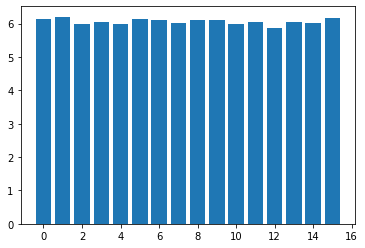

In [8]:
%matplotlib inline
plt.bar(np.arange(16), time_it_took)
plt.show()

# Here we plot the runtime as n increases

Only plotting as n goes from 1 to 5 as we get timeout error after that and only plotting for function which returns 1 for all 0 input. We are also conducting 10000 trials (more than previous as we only have 5 functions instead of 16.

Note that answer when n=1 is incorrect half the time because grovers algorithm is stuck in bell states for that case and we get 0 or 1 with equal probablity

In [11]:
time_it_took = []
lst_bitseq = [[0],[0,0],[0,0,0],[0,0,0,0],[0,0,0,0,0]]

for i in range(len(lst_bitseq)):
    start = time.time()
    run_circuit(lambda x: 1 if x == lst_bitseq[i] else 0, i+1,10000)
    end = time.time()
    time_it_took.append(end-start)

**************************************************
qubit 0 is 1 with probability 50.84%
f(x) = 1 for input x=1 with probability 50.840%
**************************************************
**************************************************
qubit 0 is 0 with probability 91.17%
qubit 1 is 0 with probability 90.9%
f(x) = 1 for input x=00 with probability 82.874%
**************************************************
**************************************************
qubit 0 is 0 with probability 53.72%
qubit 1 is 0 with probability 57.88%
qubit 2 is 0 with probability 59.29%
f(x) = 1 for input x=000 with probability 18.435%
**************************************************
**************************************************
qubit 0 is 1 with probability 59.87%
qubit 1 is 1 with probability 55.92%
qubit 2 is 1 with probability 50.32%
qubit 3 is 0 with probability 51.05%
f(x) = 1 for input x=1110 with probability 8.600%
**************************************************
**************************

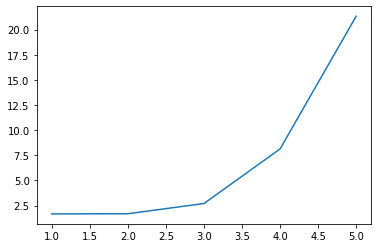

In [18]:
%matplotlib inline
plt.plot(list(range(1,6)), time_it_took)
plt.show()

# How to use our code?

Running this is straightforward. We have a function called run_circuit which takes 3 arguments. The first argument is the name of the function that we are using. 2nd argument is length of the input to this function. 3rd argument is number of trials we want to run this circuit